# Histopathological image classification Challenge

### Authors: 
#### Charlotte LACLAU (charlotte.laclau@telecom-paris.fr ),   Awais SANI (awais.sani@telecom-paris.fr)


#### Yiboe Ossee
MS IA

## Context

For this data challenge, you will work on histopathological images. The dataset consists of microscopic images of breast tumor tissue collected from several patients. These images have the following properties: 700x460 pixels, 3-channel RGB, 8-bit depth in each channel, PNG format.  

You will be provided with two subfolders. 
- **Train** contains the set of training images (with labels)
- **Test** contains the set of images on which you will be evaluated (no available labels)

### Objective and Evaluation metrics
These images correspond to samples of breast tumors that are either benign or malignant. Among malginants, we can also distinguish between different types of tumors. For this data challenge, you will be evaluated on the prediction of the type of tumors (8 possible classes). 

The chosen metric for this evalaution is the F1-Score (weighted average) implemented in scikit-learn (`sklearn.metrics.f1_score`).

### LeaderBoard Explanation

You will be evaluated on the test set and your score will be displayed on a public learderboard available at      

datachallenge.enst.fr

To limit overfitting on the test set, the number of submissions is limited to 2 per day for each team. Every time a team submits a solution, the score is displayed and updated on the leaderboard. 

### About the subject :

Developing accurate machine learning models for tasks such as cancer detection and diagnosis is crucial in improving patient outcomes. However, effective analysis of histopathological images requires a deep understanding of the underlying biology and morphology of the tissues being analyzed.

Histopathological images contain complex information, including various patterns and textures that may indicate the presence of disease. As a result, extracting meaningful features from these images requires knowledge of the different cellular structures and histological characteristics associated with different types of cancer cells. Histopathological images often exhibit high variability, which can make it challenging to develop a robust feature extraction pipeline. To overcome this challenge, researchers rely on domain-specific knowledge to identify relevant features and develop effective preprocessing techniques.

Recent studies have focused on the use of deep learning methods to improve the accuracy of histopathological image analysis. These methods have shown promising results in identifying cancer cells and predicting disease outcomes. However, the interpretability of deep learning models remains a challenge, highlighting the need for continued research on feature extraction and model interpretability in histopathological image analysis.

Overall, a deep understanding of the underlying biology and morphology of the tissues being analyzed is essential in developing effective machine learning models for histopathological image analysis.

Related articles:

- "Deep Learning for Histopathological Image Analysis: A Review" by Anant Madabhushi and George Lee.

- "Machine Learning Methods for Histopathological Image Analysis: A Review" by Jonathan de Matos, Steve Tsham Mpinda Ataky, Alceu de Souza Britto Jr., Luiz Eduardo Soares de Oliveira and Alessandro Lameiras Koerich. 

- "Classification of Histopathological Images using Scale-Invariant Feature Transform" by Andrzej Bukała, Bogusław Cyganek, Michał Koziarski, Bogdan Kwolek, Bogusław Olborski, Zbigniew Antosz1, Jakub Swadzba and Piotr Sitkowski.


In [ ]:
import sys 
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    

### Some imports

Here are some imports that will be useful for the data challenge
* cv2 : `!pip install opencv-python`
* scikit-image: `!pip install scikit-image`
* scikit-learn: `!pip install scikit-learn`

In [ ]:
#!pip install mahotas== --no-cache-dir -I | grep mahotas
#!pip install mahotas==1.4.12

In [ ]:
!pip install numpy
import numpy as np
import pandas as pd
import cv2
import mahotas as mht
import os
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage import io
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score

### Setting of files directory 

In [ ]:
import os
IN_COLAB = False

if IN_COLAB:
    ROOT_PATH = '/data-challenge2/'
else:
    ROOT_PATH = '/Users/jojo/Downloads/data-challenge2/'
TRAIN_PATH = ROOT_PATH + 'Train/'
TEST_PATH = ROOT_PATH + 'Test/'
VER_PATH = ROOT_PATH + 'TestBis/'
#GRAY_PATH = ROOT_PATH + 'Gray/'
#MODELS_PATH = ROOT_PATH + 'models_challenge/'
ALL_IMAGES_PATH = ROOT_PATH + 'all_images/'
os.chdir(ROOT_PATH)
#!ls

In [ ]:
def set_pandas_display_options() -> None:
    """Set pandas display options."""
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 1000
    display.max_colwidth = 199
    display.width = 1000
    # display.precision = 2  # set as needed

set_pandas_display_options()

### Getting the data 

To download the data, follow this link - then unzip the file

https://partage.imt.fr/index.php/s/RQSJsEpSjkc9oTZ

### Training Data visualisation

* A first step is to create the list of all available images using the `os.listdir` function provided by `os` library (https://docs.python.org/3/library/os.html).

* Hereafter we wrote the code to get all the filenames, print the total number of files and show the first image of the list using `skimage.io` library (https://scikit-image.org/docs/dev/api/skimage.io.html)

Number of images:  422


<function skimage.io._io.show()>

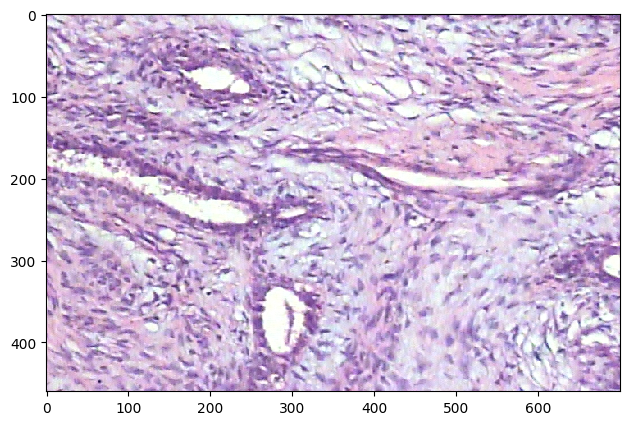

In [ ]:
from skimage import io


# get images list from folder using os.listdir
images = os.listdir(path=TRAIN_PATH)

# Number of images
print("Number of images: ", len(images))

# Image visualisation
io.imshow(TRAIN_PATH + images[0])
io.show

### Dataset building

* Now we can build a pandas `DataFrame` to store the information about the images. All the informations are contained in the filename of each image. 

* For example, SOB_B_TA-14-4659-40-001.png is the image 1, at magnification factor 40X, of a benign tumor of type tubular adenoma, original from the slide 14-4659, which was collected by procedure SOB. 

* Using the function `str.split` we can create new columns in the dataframe corresponding to the class, subclass and slide from each image.

In [ ]:
def parse_fn(filename):
    # <BIOPSY_PROCEDURE>_<TUMOR_CLASS>_<TUMOR_TYPE>-<YEAR>-<SLIDE_ID>-<MAG>-<SEQ>
    parsed = filename[:-4].replace('-', '_').split('_')
    parsed.append(filename)
    return parsed

columns = ['procedure', 'class', 'type', 'magnification', 'slide', 'mag', 'seq', 'filename']

df = pd.DataFrame(list(map(parse_fn, images)), columns=columns)
label_types = df['type'].unique()


**Encoding MUST be done with the following correspondance**

F->1
DC->2 
PC->3
PT->4
MC->5
LC->6
A->7
TA->8

In [ ]:
label_maps = {'F':'1', 'DC':'2', 'PC':'3', 'PT':'4', 'MC':'5', 'LC':'6', 'A':'7', 'TA':'8'}
df['type_id'] = df['type'].apply(lambda x: label_maps[x])

#print(df.head(10))


In [ ]:
#df_B_type = df[df['class'] == 'B']
#df_B_type['type'].value_counts().plot(kind='bar', xlabel='type', ylabel='Count', rot=0)

#df_M_type = df[df['class']== 'M']
#df_M_type['type'].value_counts().plot(kind='bar', xlabel = 'type', ylabel='Count', rot=0)

df['type_id'].value_counts()#.plot(kind='bar', xlabel = 'type', ylabel='Count', rot=0)

3    92
1    72
7    65
5    58
4    57
2    46
6    16
8    16
Name: type_id, dtype: int64

* Now you can create a more advanced visualisation of the images like shown below by using `ImageGrid` object from the `matplotlib` library (https://matplotlib.org/3.1.3/gallery/axes_grid1/simple_axesgrid.html). Here we visualise the 4 first images of each class.

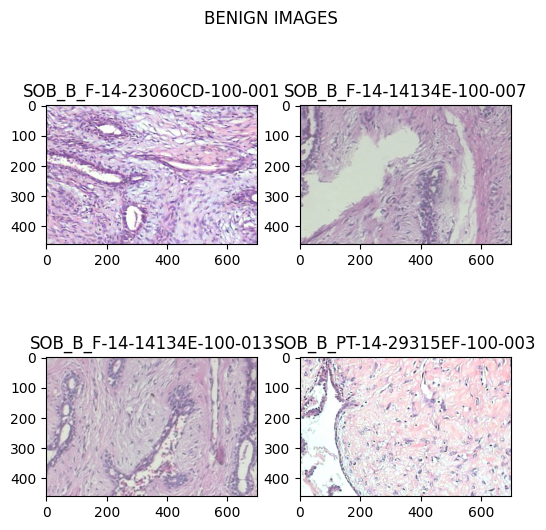

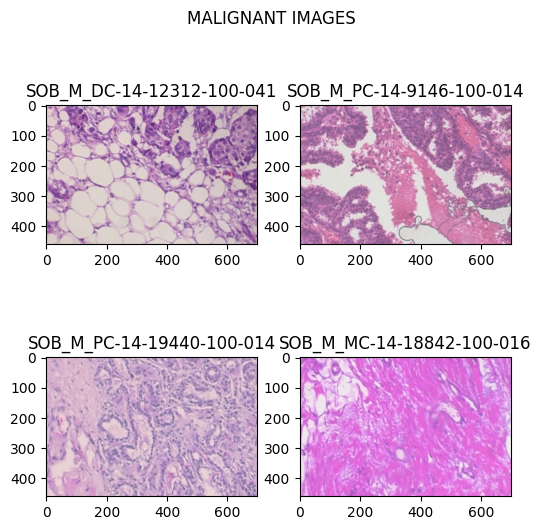

In [ ]:
# plot 4 images for each class
b_img = df[df['class'] == 'B'].head(4)
m_img = df[df['class'] == 'M'].head(4)

for class_name, class_images in [['BENIGN', b_img], ['MALIGNANT', m_img]]:
    fig, axs = plt.subplots(2,2,figsize=(6, 6))
    fig.suptitle('{0} IMAGES'.format(class_name), fontsize=12)
    i = 0
    j = 0
    for idx, img in class_images.iterrows():
        ax = axs[i, j]
        ax.set_title(img['filename'][:-4])
        ax.imshow(io.imread(TRAIN_PATH + img['filename']))
        j = j + 1 if j < 1 else 0
        i = i + 1 if j == 0 else i
    fig.show()

### Examples of features extraction (from image processing)

* To perform machine learning, you need to map each image to a vector or representation. 

* Feature extraction is necessary to extract information from the raw data, in order to enrich their description. Selecting the most meaningful features is a crucial step in the process of classification problems.

* The selected set of features should be a small set whose values efficiently discriminate among patterns of the different classes, but are similar for patterns within the same class.

* Here we will calculate 3 global features on each image. To do so, we can use functions from `OpenCV` and `mahotas` libraries: 

  * Hu moments: https://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html
  * Haralick: https://mahotas.readthedocs.io/en/latest/features.html
  * Color histogram in HSV: https://docs.opencv.org/master/dd/d0d/tutorial_py_2d_histogram.html

**We choose to perform all the pre-processing and features extraction parts on both training and test images at the start.**

In [ ]:
## Some more imports

import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans
from skimage import color
#!pip install opencv-python==4.7.0.68

#!pip install opencv-contrib-python==4.7.0.68

In [ ]:
# Extract images from Test images and Train + Test images

test_images = os.listdir(path=TEST_PATH)
print("Number of images: ", len(test_images))

all_images = os.listdir(path= ALL_IMAGES_PATH)
print("Number of images: ", len(all_images))


Number of images:  207
Number of images:  629


### **Extract the features** 


In image processing for machine learning, it is essential to convert each image into a vector or representation, which requires extracting features.

- The process of feature extraction helps to derive useful information from raw image data, enhancing their description. Choosing the most relevant features is critical for effective classification.

- The ideal set of features should be concise and effectively distinguish patterns among various classes while being consistent for patterns within the same class.


We compute in this part the dollowing different features :

- Hu
Hu Moments, also known as Hu invariants, are a set of seven mathematical moments used to describe the shape of an object or image. They were developed by M. K. Hu in 1962 and are widely used in image processing and computer vision applications, such as object recognition and tracking.

- Haralick,
Robert Haralick is a computer scientist known for his contributions to the field of image analysis and pattern recognition. He has made significant contributions to the development of texture analysis methods, including the co-occurrence matrix and gray-level co-occurrence matrix (GLCM), which are widely used for image feature extraction.

- Color Histogram
A Color Histogram is a representation of the distribution of colors in an image. It shows the frequency of occurrence of each color in the image, which can be useful for tasks such as image retrieval and object recognition. Color histograms are often used as a feature descriptor in computer vision and image processing applications.

- Bag of features

Bag of Features is a technique used for image classification and object recognition. It involves extracting local features from an image, such as SIFT or SURF descriptors, and then creating a visual vocabulary or codebook of these features. The images are then represented as a histogram of the frequency of occurrence of each feature in the codebook, which can be used as a feature descriptor for classification. Bag of features is a popular technique in computer vision and has been used in various applications, such as image retrieval, scene recognition, and object recognition.

In [ ]:
# parameters for the features extraction
bins = 11

# functions to extract features from the images
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mht.features.haralick(gray).mean(axis=0)
    return haralick

def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()



### **SIFT Features Extraction (Scale-Invariant Feature Transform)**


**SIFT features** refer to local features that remain invariant to scale, rotation, and translation, enabling the detection of the same feature in an image regardless of its size, orientation, or position. SIFT operates by identifying various keypoints in an image and obtaining a description for each one, where a keypoint is a region of the image that stands out due to its brightness or gradient strength.

The SIFT algorithm involves four main steps.

First, the image is transformed into a scale-space representation by convolving it with Gaussian kernels of progressively larger sizes, and then local extrema (maxima and minima) in the scale space are identified as potential keypoints. 

Next, keypoints that have low contrast, are too edge-like, or are situated in an unstable area are eliminated. 

The method then determines the orientation for each keypoint based on the gradient axes of adjacent pixels, resulting in rotation-invariant features. 

Finally, a feature description is generated for each keypoint by constructing a histogram of the gradient orientations in the immediate vicinity, producing a vector of numbers reflecting the local image structure surrounding the keypoint.

Here we implemented the Bag of Features using a technique that combined both the Train and Test images to obtained a complete representation of the patterns needed to be recognized in the images. 
**One advantage of SIFT features is their robustness to scaling, rotation, and translation.**



This code implements a **Bag of Features (BoF) method using SIFT features for image classification**. 

The code uses the OpenCV library's SIFT feature extraction algorithm to extract local feature descriptors from the images. The extract_sift_features function reads images from a given path, extracts SIFT descriptors for each image using the SIFT feature extractor, and returns a list of these descriptors for each image. 

The kmeans_bow function uses K-means clustering to cluster all the SIFT descriptors from all images into a predefined number of clusters, and returns the cluster centers as a BoF dictionary.

The create_features_bow function takes the list of SIFT descriptors for each image, the BoF dictionary, and the number of clusters, and constructs the BoF feature vectors for each image by counting the occurrences of the SIFT descriptors in the BoF dictionary. 

The code then loads or creates the BoF dictionary using kmeans_bow, and extracts the BoF features for the images in the training, test, and validation datasets using create_features_bow. 

Overall, this code demonstrates an implementation of a common BoF method for image classification using SIFT features and K-means clustering. 

https://www.scitepress.org/Papers/2020/91634/91634.pdf
https://arxiv.org/pdf/2102.03889.pdf

In [ ]:
import pickle
import sklearn

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist


def extract_sift_features(X, path):
    image_descriptors = []
    sift = cv2.xfeatures2d.SIFT_create()

    for i in range(len(X)):
        img = cv2.imread(path + X[i])
        kp, des = sift.detectAndCompute(img, None)
        image_descriptors.append(des)

    return image_descriptors

def kmeans_bow(all_descriptors, num_clusters):
    bow_dict = []
    kmeans = KMeans(n_clusters=num_clusters).fit(all_descriptors)
    bow_dict = kmeans.cluster_centers_
    return bow_dict

def create_features_bow(image_descriptors, BoW, num_clusters):
    X_features = []
    for i in range(len(image_descriptors)):
        features = np.array([0] * num_clusters)

        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], BoW)
            argmin = np.argmin(distance, axis=1)
            for j in argmin:
                features[j] += 1
        X_features.append(features)
    return X_features

print("Extraction")

# Extract all images 
image_descriptors = extract_sift_features(all_images, ALL_IMAGES_PATH)

all_descriptors = []
for descriptors in image_descriptors:
    if descriptors is not None:
        for des in descriptors:
            all_descriptors.append(des)

num_clusters = 200
print("Before Bow")

# Build the vocabulary
if not os.path.isfile(ROOT_PATH + 'bow_dictionary150.pkl'):
    BoW = kmeans_bow(all_descriptors, num_clusters)
    pickle.dump(BoW, open(ROOT_PATH + 'bow_dictionary150.pkl', 'wb'))
else:
    BoW = pickle.load(open(ROOT_PATH + 'bow_dictionary150.pkl', 'rb'))

print("After Bow")
# Extract features from train, test and validation data
images_descriptors = extract_sift_features(images, TRAIN_PATH)
X_bow1 = create_features_bow(images_descriptors, BoW, num_clusters)
print("Now test")
test_images_descriptors = extract_sift_features(test_images, TEST_PATH)
X_bow2 = create_features_bow(test_images_descriptors, BoW, num_clusters)


Extraction
Before Bow
After Bow
Now test


In [ ]:
# Process the bag of features into Arrays
lst_X_bow_train = np.asarray([list(element)for element in X_bow1])
lst_X_bow_test = np.asarray([list(element)for element in X_bow2])

lst_X_bow_train.shape,lst_X_bow_test.shape 

((422, 200), (207, 200))

In [ ]:
# Parse images name into dataframe
def parseTest_fn(filename):
    
    # <BIOPSY_PROCEDURE>_<ID>
    parsed = filename[:-4].split('_')
    parsed.append(filename)
    return parsed

def parsing_images_names(test_images) :
    
    columns = ['procedure', 'id', 'filename']
    df_test = pd.DataFrame(list(map(parseTest_fn, test_images)), columns=columns)
    
    return df_test



#### Features extraction functions used :

The **extract_3features** function extracts three types of features from a set of images, concatenates them together into a single feature vector for each image, and returns a matrix where each row represents an image and each column represents a feature.

On the other hand, the **separate_features** function extracts the same three types of features from a set of images, but instead of concatenating them together, it returns them as three separate matrices, where each row represents an image and each column represents a single feature type.

- **The hist_color_train variable is a version of the color histogram also tested which give pratically similar results so it was dropped moving forward.** 


In [ ]:
# define function to extract color histogram from image
def extract_color_histogram(image):
    
    # convert image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # set histogram parameters
    hist_size = [8, 8, 8]
    ranges = [0, 256, 0, 256, 0, 256]
    
    # calculate histogram
    hist = cv2.calcHist([hsv], [0, 1, 2], None, hist_size, ranges)
    
    # normalize histogram
    hist = cv2.normalize(hist, hist)
    
    return hist.flatten()

def compute_color_hist(images, path):
    
    # add code here to load images and their corresponding labels
    features = np.zeros((len(images), 512))
    for i, image in enumerate(images):
        image = cv2.imread(path + image)  # Load image
        features[i] = extract_color_histogram(image)
    
    return features

# Extract Haralick, Color and Hu features
def separate_features (images,path):
    
    feat_haralick = []
    feat_histogram = []
    feat_hu = []
    for i in images:
        img = cv2.imread(path + i)  # Load image
        feat_hu.append(fd_hu_moments(img))  # Append Hu values
        feat_haralick.append(fd_haralick(img))  # Append Haralick values
        feat_histogram.append(fd_histogram(img))  # Append Histogram values
        
    hist_color = compute_color_hist(images, path)
    return feat_histogram ,feat_haralick, feat_hu ,hist_color


def extract_3features (images,path):
    
    feat_histogram ,feat_haralick, feat_hu, hist_color = separate_features (images,path)
    
    # Concatenate the features in a DataFrame
    features_3 = np.concatenate((feat_histogram ,feat_haralick, feat_hu, hist_color), axis=1) 
    
    return features_3


In [ ]:
# Extract the features : Hu, Haralick and Histogram of colour values
feat3_train = extract_3features (images,TRAIN_PATH)
feat3_test = extract_3features (test_images,TEST_PATH)

# Extract each feature : Hu, Haralick and Histogram of colour values
feat_histogram_train, feat_haralick_train, feat_hu_train, hist_color_train = separate_features (images,TRAIN_PATH)
feat_histogram_test, feat_haralick_test, feat_hu_test, hist_color_test = separate_features (test_images,TEST_PATH)


#### Concatenating all the features and saving them

The code is concatenating the bag of features (BOW) with the three other types of features (Hu, Haralick, and Histogram of color values), and then saving the resulting feature matrices as CSV files.

This can be a useful approach for preparing data for machine learning models, since many models require input data to be in a tabular format (e.g. as a matrix or dataframe), where each row represents a sample and each column represents a feature.

By concatenating the BOW features with the other features, the resulting feature matrix captures both the visual content of the images (through the BOW features) and other relevant image properties (through the other types of features).

Saving the resulting feature matrices as CSV files can be useful for later loading into machine learning models or for sharing with systems that require the data in this format.

- Concatenate the bag of features with the 3 other features : Hu, Haralick,Histogram and Histogram of colour values
- Save all features as csv

- Then we process **y** to fit it to XGb Classifer we will be using in the next part.

In [ ]:
# Concatenate the bag of features with the 3 other type of features : Hu, Haralick,Histogram and Histogram of colour values

features_train = pd.DataFrame(np.concatenate((feat3_train, lst_X_bow_train), axis=1))
features_test = pd.DataFrame(np.concatenate((feat3_test, lst_X_bow_test), axis=1))


In [ ]:
# Save all features as csv
features_train.to_csv('features_train.csv', index=False, header=False)
features_test.to_csv('features_test.csv', index=False, header=False)


In [ ]:
# Adapting y to XGB Classifer 
y = df['type_id'].astype('int') -1


## Comments :

During the challenge, we implemented and experimented a set of features, which can be divided into local and global features.

Local features are image attributes that describe specific regions within an image, and they are often extracted using algorithms such as SIFT. These features are based on keypoints or regions that stand out in terms of intensity or gradient magnitude. Local features are useful for tasks such as image matching and object recognition since they are often robust to changes in scale, rotation, and lighting.

On the other hand, global features describe the overall image, and they can be extracted using methods such as color histograms and GIST features. Global features are typically represented as a vector of numerical values that describe the color, texture, and spatial arrangement of the image. They are often used for applications such as image retrieval and scene recognition.

- **During the challenge, we also experimented with other features such as HOG histogram, HU, HSV histogram, and LBP. We tested various combinations of features and classifiers using cross-validation to evaluate their performances.** 

- **Another approach consisted of learning one model to predict classes Benign and Malign and two others models: each for the subclasses or the types of tumors that are referenced for the two classes.**  

**Although some combinations gave satisfactory results, the results were not that satisfaying so decided to keep as features the set : Haralick + Hue + Feat Histogram + Hist_color.**

We performed LOOCV to confirm the effectiveness of our models on the features selected. 

We first evaluated our predictions using train_test_split and submitted acceptable results but we found out later that :

- **the scores were slightly different than the one the submission site.**

- **The performance scores were better on the submission without train_test_split sinc the models got to train on more data.**

- **The most important difficulty was the prediction for the class 6.**



# **Models' training** 

We start by considering several modules from popular machine learning libraries from scikit-learn such as rfc, gb, xgboost, knn and SVM.

The models being imported include:

- RandomForestClassifier: a decision tree-based ensemble method that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

- GradientBoostingClassifier: a gradient boosting algorithm that builds an ensemble of decision trees, where each tree tries to correct the mistakes of the previous tree.

- XGBClassifier: a gradient boosting algorithm that uses a more regularized model formalization to prevent over-fitting and improve predictive accuracy.

- SVC: a classification algorithm that separates classes by hyperplanes in a high-dimensional space. 

- KNeighborsClassifier: a classification algorithm that assigns a test sample to the class most common among its k nearest neighbors in the training set.

- VotingClassifier: a model that aggregates the predictions of multiple models to make a final prediction. 

Additionally, this part will implement functions for **model selection**, **hyperparameter tuning**, and **model evaluation**.

These models will be trained and evaluated using the imported functions, with the goal of finding the best-performing model for the given task. 

Our approaches where the following :

- 1. **Making prediction with the three (3) features ensemble**
- 2. **Making prediction with each of the three (3) features**
- 3. **Training with the best type of features and the bests models

**The first approach gave the intermediary results and the (2.- 3.) was the method that helps us achieve a better performance.**

In [ ]:
#Make the importations
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from sklearn.svm import SVC


## **1. Making prediction with the three (3) features ensemble**

We make here a Leave-One-Out Cross validation with differents models on the 3 features ensemble to evaluate their performance:

- XGBClassifier
- RandomForestClassifier
- GradientBoostingClassifier
- SVC
- KNeighborsClassifier
- VotingClassifier

### **1.1 Leave_one_out cross validation**

**Leave-One-Out cross-validation (LOOCV)** is a method of cross-validation in which each sample in the dataset is used as the validation data exactly once, while the rest of the samples are used for training the model.

- This means that for a dataset with N samples, LOOCV will perform N rounds of training and testing, where in each round, one sample is left out for testing, and the remaining N-1 samples are used for training. The final performance of the model is typically measured as the average performance across all rounds.

- LOOCV is a useful method when working with small datasets, as it maximizes the use of available data for both training and testing, and provides an unbiased estimate of model performance. However, it can be computationally expensive and time-consuming, especially for large datasets.

In the context of machine learning, **LOOCV is used to estimate the generalization error of a model, i.e., how well the model will perform on new, unseen data**. 

It can also be used for hyperparameter tuning and model selection, where different models and hyperparameters are evaluated using LOOCV to determine the best-performing combination.

**We will apply it on the training data with the six (8) following models conseidered to estimate their capacity to perform well on the submission data**: 

##### Initialize the models to evaluate

- **rfc = RandomForestClassifier()**

- **xgb = XGBClassifier()**

- **gb = GradientBoostingClassifier()**

- **svc = SVC(probability=True)**

- **knn = KNeighborsClassifier()**

- **vt3 = VotingClassifier(estimators=[('rfc', rfc), ('xgb', xgb), ('gb', gb)], voting='soft')**

- **vt5 = VotingClassifier(estimators=[('rfc', rfc), ('xgb', xgb), ('gb', gb), ('svc', svc), ('knn', knn)], voting='soft')**

- **vt = VotingClassifier(estimators=[('vt3', vt3), ('vt5', vt5)], voting='soft')**

**Those LOOCV experimentations gave us the following results :**

In [ ]:
## Displaying the approximate results of submission

import pandas as pd

data = {'models': ['rfc', 'xgb', 'gb', 'svc', 'knn', 'vt3', 'vt5', 'vt'],
        'accuracy': [0.895735, 0.860190, 0.829384, 0.270142, 0.246445, 0.883886, 0.881517, 0.881517],
        'f1_score': [0.894094, 0.847032, 0.789367, 0.119599, 0.184486, 0.860312, 0.860966, None]}

df = pd.DataFrame(data)
print(df)


  models  accuracy  f1_score
0    rfc  0.895735  0.894094
1    xgb  0.860190  0.847032
2     gb  0.829384  0.789367
3    svc  0.270142  0.119599
4    knn  0.246445  0.184486
5    vt3  0.883886  0.860312
6    vt5  0.881517  0.860966
7     vt  0.881517       NaN


#### Results obtained  :

**As we can see, the random forest classifier (rfc) achieved the highest accuracy and f1 score, followed by the voting classifier with the top 3 best models (vt3, vt5, vt) coming in very close.**

### **1.2 Grid Search on the best simple models**



Grid search is a hyperparameter optimization technique that involves **searching over a specified hyperparameter space for the optimal set of hyperparameters that results in the best performance of a given model**. 

It involves **specifying a grid of hyperparameters to search over, and then fitting the model with each possible combination of hyperparameters in the grid**. 

- **The optimal set of hyperparameters is then chosen based on the evaluation metric of interest, such as accuracy, F1 score, or mean squared error.**

Grid search is a common approach for **fine-tuning machine learning models to achieve better performance on specific tasks**. It is used here with a wide range of machine learning algorithms, such as **support random forest, xgb and gradient boost**. 

**By tuning the hyperparameters of a model using grid search, we can improve its generalization performance, reduce overfitting, and obtain better results on new data.**

**We choosed to run it with :**

- **XGB Classifier : param_grid = {'learning_rate': [0.1, 0.2, 0.3],'max_depth': [5, 8, 9, 10, 15],'n_estimators': [50, 100, 150],}** 

- **RFC : param_grid = {'n_estimators': [50, 100, 150, 200],'max_depth': [3, 5, 7, 9, 10, 15, None],'min_samples_split': [2, 3],'min_samples_leaf': [1, 2],'random_state': [12, 28, 32, 42, 80]}**

- **GB : param_grid = {'n_estimators': [50,100,150,200],'max_depth': [3,5,7, 9, 10, 15, None],'subsample': [0.75],'learning_rate' : [0.1, 0.2],'random_state': [12,28, 32, 42, 55, 88]}**



#### Results :

- **Best Parameters for XGBoost:  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150}**

- **Best Score for XGBoost: 0.74**

- **Best Parameters for Random Forest:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150, 'random_state': 28}**

- **Best Score for Random Forest: 0.81**

- **Best Parameters for Gradient Boosting Classifier:  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50, 'random_state': 88, 'subsample': 0.75}**

- **Best Score for Gradient Boosting Classifier: 0.73**


These results of the grid search show the best parameters and scores for three different models: **XGBoost, Random Forest, and Gradient Boosting Classifier.** 

- **For XGBoost, the best parameters are learning rate of 0.1, max depth of 10, and 150 estimators with a score of 0.74.** 


- **For Random Forest, the best parameters are no maximum depth, minimum samples per leaf of 1, minimum samples per split of 2, 150 estimators, and random state of 28 with a score of 0.81.**


- **For Gradient Boosting Classifier, the best parameters are a learning rate of 0.1, max depth of 10, 50 estimators, random state of 88, and subsample of 0.75 with a score of 0.73.** 


**These results will be used to further optimize the performance of the models in the classification task.**

### **1.3 Training the best simple models with the best parameters and evaluating their performances**

- train the model
- evaluate it performance on Test data

#### Train the models with the best parameters from the Grid Searches

#### Initialize the base estimators

- **rfc = RandomForestClassifier()**

- **xgb = XGBClassifier()**

- **gb = GradientBoostingClassifier()**

#### Get the best models from grid search

- **best_rfc = rfc.set_params(**rfc3_grid_params)**

- **best_xgb = xgb.set_params(**xgb3_grid_params)**

- **best_gb = gb.set_params(**gb3_grid_params)**

- **best_voting3 = VotingClassifier(estimators=[('best_rfc', best_rfc), ('best_xgb', best_xgb), ('best_gb', best_gb)], voting='soft')**


####  Evaluate it performance on Test data

**After fitting the models on the training set, we obtained the approximated following scores on submission.**

**We display in this part for each of the previously trained models implemented the scores obtained on the test data considering all the 3 features.**

In [ ]:
## Displaying the approximate results of submission

results = {'models': ['best_rfc', 'best_xgb', 'best_gb', 'best_voting3'],
           'accuracy': [0.769130, 0.788792, 0.768792, 0.797778],
           'f1_score': [0.694998, 0.714824, 0.681722, 0.728354]}

df1 = pd.DataFrame(results)
print(df1)

         models  accuracy  f1_score
0      best_rfc  0.769130  0.694998
1      best_xgb  0.788792  0.714824
2       best_gb  0.768792  0.681722
3  best_voting3  0.797778  0.728354


#### Comments : 

- **This approach with all the experimentations along its realisation, achieved all the performances with predictions'F1_score in 0.64_0.72**

- **An F1 score in the range of 0.64 to 0.72 suggests that the model is performing reasonably well, but there may still be room for improvement.**

- **It's important to keep in mind that the performance of a machine learning model can be affected by many factors, including the quality and quantity of the data used to train the model, the choice of features and algorithms, and the hyperparameters selected during the training process.**

**To tackle this, we chose to explore the choice of features still while adapting the training strategies with models' selections and hyperparameters tuning.**

#### To note :

**All the processing in this Part 1. have been also realised using the SIFT method for Bag of Features (BoF) implemented in the features extraction paragraph.** 
**Still the results were good but not really more impactful. So we choose to mention it brievely but not include a repetition of the current steps on the concatenation of all the features ( Hue, Haralick, Color Histogram  + SIFT).**

**The following part presents which methos actually gave the best performance results :**

- **2. Making prediction with each of the three (3) features**
- **3.Training with the best type of features and the bests models**

## **2. Making prediction with each of the three (3) features**

### **Leave-one-out Cross validation**

For each type of features extracted (feat_histogram_train, feat_haralick_train, feat_hu_train and hist_color_train) to implement this method to evaluate all the models performance.

In [ ]:
# Listing all the features and features name
liste_features = [np.array(feat_histogram_train), np.array(feat_haralick_train), np.array(feat_hu_train), np.array(hist_color_train)]
liste_features_name = ['feat_histogram_train', 'feat_haralick_train', 'feat_hu_train', 'hist_color_train']

# Initialize the models to evaluate
rfc = RandomForestClassifier()
xgb = XGBClassifier()
gb = GradientBoostingClassifier()
svc = SVC(probability=True)
knn = KNeighborsClassifier()
vt3 = VotingClassifier(estimators=[('rfc', rfc), ('xgb', xgb), ('gb', gb)], voting='soft')
vt5 = VotingClassifier(estimators=[('rfc', rfc), ('xgb', xgb), ('gb', gb), ('svc', svc), ('knn', knn)], voting='soft')
vt = VotingClassifier(estimators=[('vt3', vt3), ('vt5', vt5)], voting='soft')

# Listing all the models and models name
models =[rfc, xgb, gb, svc, knn, vt3, vt5, vt]
models_name = ['rfc', 'xgb', 'gb', 'svc', 'knn', 'vt3', 'vt5','vt' ]


scores = []

for i, feature in enumerate(liste_features) : 
    
    print("For ",liste_features_name[i], "\n")
    scores.append(loo_all_models (feature, y, models, models_name))
    
for i, dataframe in enumerate(scores) :
    
    print("For ",liste_features_name[i], "\n")
    dataframe.to_csv(liste_features_name[i] + '_evaluation')
    

For  feat_histogram_train 

For  feat_haralick_train 

For  feat_hu_train 

For  hist_color_train 



#### Displaying the Leave-one out Cross validation results for all the model on all the features


In [ ]:
for i, dataframe in enumerate(scores) :
    
    print("For ",liste_features_name[i], "\n")
    print(dataframe.head(8),"\n")

For  feat_histogram_train 

  models  accuracy  f1_score
0    rfc  0.879147  0.875279
1    xgb  0.845972  0.847725
2     gb  0.805687  0.763275
3    svc  0.779621  0.763708
4    knn  0.736967  0.739017
5    vt3  0.862559  0.847745
6    vt5  0.864929  0.857271
7     vt  0.862559  0.850718 

For  feat_haralick_train 

  models  accuracy  f1_score
0    rfc  0.471564  0.396787
1    xgb  0.502370  0.480058
2     gb  0.454976  0.369416
3    svc  0.239336  0.097988
4    knn  0.246445  0.184486
5    vt3  0.485782  0.420375
6    vt5  0.488152  0.415456
7     vt  0.490521  0.424725 

For  feat_hu_train 

  models  accuracy  f1_score
0    rfc  0.165877  0.118299
1    xgb  0.298578  0.273239
2     gb  0.158768  0.124481
3    svc  0.218009  0.044747
4    knn  0.246445  0.186909
5    vt3  0.241706  0.189913
6    vt5  0.220379  0.167852
7     vt  0.232227  0.183023 

For  hist_color_train 

  models  accuracy  f1_score
0    rfc  0.845972  0.840479
1    xgb  0.841232  0.845933
2     gb  0.808057  0.79

#### Results :

Based on the results, it seems that :

- **the histogram features are the most informative ones for this classification task, with Random Forest Classifier achieving the highest accuracy and F1-score.**

- **The Haralick features also showed pretty decent performance, but not as good as the histogram features.**

- **The Hu moments features performed poorly, with very low accuracy and F1-score across all models.**

- **It is also worth noting that the ensemble models (Voting Classifier) generally performed better than the individual models, especially for the histogram and Haralick features.**

**This suggests that combining multiple models can help improve performance and mitigate the weaknesses of individual models.**

- **The hist_color_train variable is a version of the color histogram also tested with pratically similar results so it was dropped.** 

## **3.Training with the best type of features and the bests models** 

- Color Histogram
- XGB Classifier, Random Forest Classifier, GB Classifer


**Methods :**

- Leave-one-out Cross Validation
- Grid Search parameters
- Models' training

### **3.1 Leave_one_out cross validation**

From the precedent results, we deduce ..

In [ ]:
# Previous results of LOOCV on the best features (color histogram features) with all the models 

print(liste_features_name[0], "\n")
print(scores[0].head(8),"\n")

feat_histogram_train 

  models  accuracy  f1_score
0    rfc  0.879147  0.875279
1    xgb  0.845972  0.847725
2     gb  0.805687  0.763275
3    svc  0.779621  0.763708
4    knn  0.736967  0.739017
5    vt3  0.862559  0.847745
6    vt5  0.864929  0.857271
7     vt  0.862559  0.850718 



#### Results : 

Based on the results of leave-one-out cross-validation for the different models on the best feature, it appears that :

- **The random forest classifier (rfc) performed the best with an accuracy of 0.879 and an f1 score of 0.875**. 

- **The gradient boosting classifier (gb) and XGBoost classifier (xgb) also performed relatively well with accuracies of 0.806 and 0.846, respectively.**

- **The support vector machine (svc) and K-nearest neighbors (knn) models performed less well with accuracies of 0.780 and 0.737, respectively.**

- **Ensemble models using voting classifier (vt, vt3, vt5) seem to perform better than individual models, with the best performing being vt5 with an accuracy of 0.865 and an f1 score of 0.857.**

### **3.2 Grid Search**

We once again use here a Grid Search with a wide random forest, xgb and gradient boost.

By tuning the hyperparameters of these models using grid search, we can **improve its generalization performance, reduce overfitting, and obtain better results on new data for the feature considered (Feat Histogram).**

In [ ]:
#Grid search on the best simple models and the best features' type
#xgb1_grid_params, xgb1_grid_score = gs_xgb (feat_histogram_train, y)
#rfc1_grid_params, rfc1_grid_score = gs_rfc (feat_histogram_train, y)
#gb1_grid_params, gb1_grid_score = gs_gb (feat_histogram_train, y)

### **3.3 Train the best models and evaluate their performances**

We train in this part the best models so far RFC, XGB, GB and voting classifier using them with the less performant such as SVC and KNN for this task and try to achieve submissions of better predictions on the test data on the best features data for the training.

**This method (feat histogram features + models (rfc, gb, xgb, voting((rfc,gb, xgb),(rfc,gb, xgb, knn, svm) and both combinations) helped us achieve the best performances with scores of f1 in 0.76-0.773**  

In [ ]:
# Initialize the random forest classifier
rfc = RandomForestClassifier(max_depth = 15, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 150, random_state =80)

# Initialize the random forest classifier
xgb = XGBClassifier(learning_rate =  0.1, max_depth = 8, n_estimators = 100)

# Initialize the random forest classifier
gb = GradientBoostingClassifier(learning_rate =  0.1, max_depth = 10, n_estimators = 150, subsample = 0.75, random_state=88) 

# Initialize the base estimators for voting3
rfc_ = RandomForestClassifier(max_depth = 15, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 150, random_state =80)
xgb_ = XGBClassifier(learning_rate =  0.1, max_depth = 8, n_estimators = 100)
gb_ = GradientBoostingClassifier(learning_rate =  0.1, max_depth = 10, n_estimators = 150, subsample = 0.75, random_state=88)

# Initialize the voting classifier
voting3 = VotingClassifier(
    estimators=[('rfc_', rfc_), ('xgb_', xgb_), ('gb_', gb_)],
    voting='soft'
)
# Initialize the base estimators for voting5
rfc_ = RandomForestClassifier(max_depth = 15, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 150, random_state =80)
xgb_ = XGBClassifier(learning_rate =  0.1, max_depth = 8, n_estimators = 100)
gb_ = GradientBoostingClassifier(learning_rate =  0.1, max_depth = 10, n_estimators = 150, subsample = 0.75, random_state=88)
svc_ = SVC(kernel='linear', C=1, gamma='scale', probability=True)
knn_ = KNeighborsClassifier(n_neighbors=11)

# Initialize the voting classifier
voting5 = VotingClassifier(
    estimators=[('rfc_', rfc_), ('xgb_', xgb_), ('gb_', gb_), ('svc_', svc_), ('knn_', knn_)],
    voting='soft'
)

# Initialize the base estimators
rfc_ = RandomForestClassifier(max_depth = 15, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 150, random_state =80)
xgb_ = XGBClassifier(learning_rate =  0.1, max_depth = 8, n_estimators = 100)
gb_ = GradientBoostingClassifier(learning_rate =  0.1, max_depth = 10, n_estimators = 150, subsample = 0.75, random_state=88)
svc_ = SVC(kernel='linear', C=1, gamma='scale', probability=True)
knn_ = KNeighborsClassifier(n_neighbors=11)


# Initialize the voting3 classifier for vt
voting3_ = VotingClassifier(
    estimators=[('rfc_', rfc_), ('xgb_', xgb_), ('gb_', gb_)],
    voting='soft'
)
# Initialize the voting5 classifier for vt
voting5_ = VotingClassifier(
    estimators=[('rfc_', rfc_), ('xgb_', xgb_), ('gb_', gb_), ('svc_', svc_), ('knn_', knn_)],
    voting='soft'
)

# Initialize the voting classifier vt
voting = VotingClassifier(
    estimators=[('v3', voting3), ('v5', voting5)],
    voting='soft'
)


# Fit the grid search to the data
rfc.fit(feat_histogram_train, y)
xgb.fit(feat_histogram_train, y)
gb.fit(feat_histogram_train, y)
voting3.fit(feat_histogram_train, y)
voting5.fit(feat_histogram_train, y)
voting.fit(feat_histogram_train, y)

print("Done\n")



Done



### **On Submission set**

### Create a submission file for the test set

For evaluation, we have to submit a csv file with image id and the predicted class.


In [ ]:
# Parse filenames from Test images
df_test = parsing_images_names(test_images)

# Make predictions on Test images
y_pred_test = voting3.predict(feat_histogram_test) +1


In [ ]:
# Create a submission file 
df_pred = pd.concat([df_test['id'], pd.Series(y_pred_test, name='type_id')], axis=1)
display(df_pred['type_id'].value_counts())
df_pred.to_csv('pred_on_test.csv', index=False, header=False)

7    55
2    42
3    38
5    25
1    23
4    23
8     1
Name: type_id, dtype: int64

### **3.4 Resulting Models' Performances**

**We submitted the results on the site and achieved the performance registered at the deadline.**

**We resume in this part for each of the previously trained models implemented the approximated scores obtained on the test data considering just the color histogram (feat_histogram).**

(For some personal reasons, we had to submit only the predictions with f1_score less than 0.77 before the the deadline. But we submit the complete report to give a better understanding of the mindset behind the results. )


In [ ]:
## Displaying the results of submission
results = {'models': ['rfc', 'xgb', 'gb', 'voting3', 'voting5', 'voting'],
           'accuracy': [0.803623, 0.827778, 0.808454, 0.842271, 0.832609, 0.837440],
           'f1_score': [0.747504, 0.762621, 0.750413, 0.773884, 0.767036, 0.770843]}

df = pd.DataFrame(results)
print(df)


    models  accuracy  f1_score
0      rfc  0.803623  0.747504
1      xgb  0.827778  0.762621
2       gb  0.808454  0.750413
3  voting3  0.842271  0.773884
4  voting5  0.832609  0.767036
5   voting  0.837440  0.770843


#### **The best performance submitted before the deadline is the one achieved with :** 

#### **XGB (learning_rate =  0.1, max_depth = 8, n_estimators = 100), with an F1_score of 0.76 and a accuracy of 0.82** 

# **Perspectives :**

We would have if possibl like to follow the following ideas of implementation :

- Using better training data: 
  - Collecting more data: One way to improve the training data is to collect more data. This can be done by generating synthetic data.
  - Augmenting the data: Data augmentation techniques can help generate more variations of the existing data. For instance, we can flip, rotate, or crop the images to create new data.
  - Removing redundant data: If the training data contains identical images as the test data ( we found out the train data contains few more than 20 images in commun with the test data), we can remove them to avoid overfitting.
  - Studying the case of 'type_id 6' images from the training and submission sets to better understand the problem's origin and find a way to work around it.  

- Exploring other feature extraction techniques: 
  - Convolutional Neural Networks (CNNs): CNNs can automatically extract relevant features from the input data and have shown remarkable performance in image classification tasks.
  - Transfer learning: we could also use pre-trained models such as VGG, ResNet, or Inception to extract features from our images and fine-tune them for a specific task.

- Implementing better models with hyperparameter tuning:
  - Kernels-based models: Kernel-based models such as Support Vector Machines (SVMs) and Gaussian Processes (GPs) can perform well on image classification tasks, even better with some less popular but rather performant kernels on image classification tasks, we would have loved to experiment on this task.

